In [1]:
import sys
import openpnm as op
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
import porespy as ps
from ipywidgets import interact, IntSlider
from openpnm.topotools import trim
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 50

In [1]:
import os
os.getcwd()

"c:\\Users\\Sa'eed\\modeling-air-injection-by-Invasion-Percolation"

In [2]:
net = op.network.Cubic([40, 25, 1], spacing=1e-5)
geo = op.geometry.SpheresAndCylinders(network=net, pores=net.Ps, throats=net.Ts)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2021-11-05 19:04:12,058
------------------------------------------------------------


In [4]:
net.labels()
net.num_throats('surface')
trim(network=net, throats=net.throats('surface'))
h = net.check_network_health()
trim(network=net, pores=h['trim_pores'])

In [5]:
im = ps.io.openpnm_to_im(net, max_dim=1000)

  0%|          | 0/996 [00:00<?, ?it/s]

  0%|          | 0/1809 [00:00<?, ?it/s]

In [9]:
print(im.shape)

(1000, 625, 25)


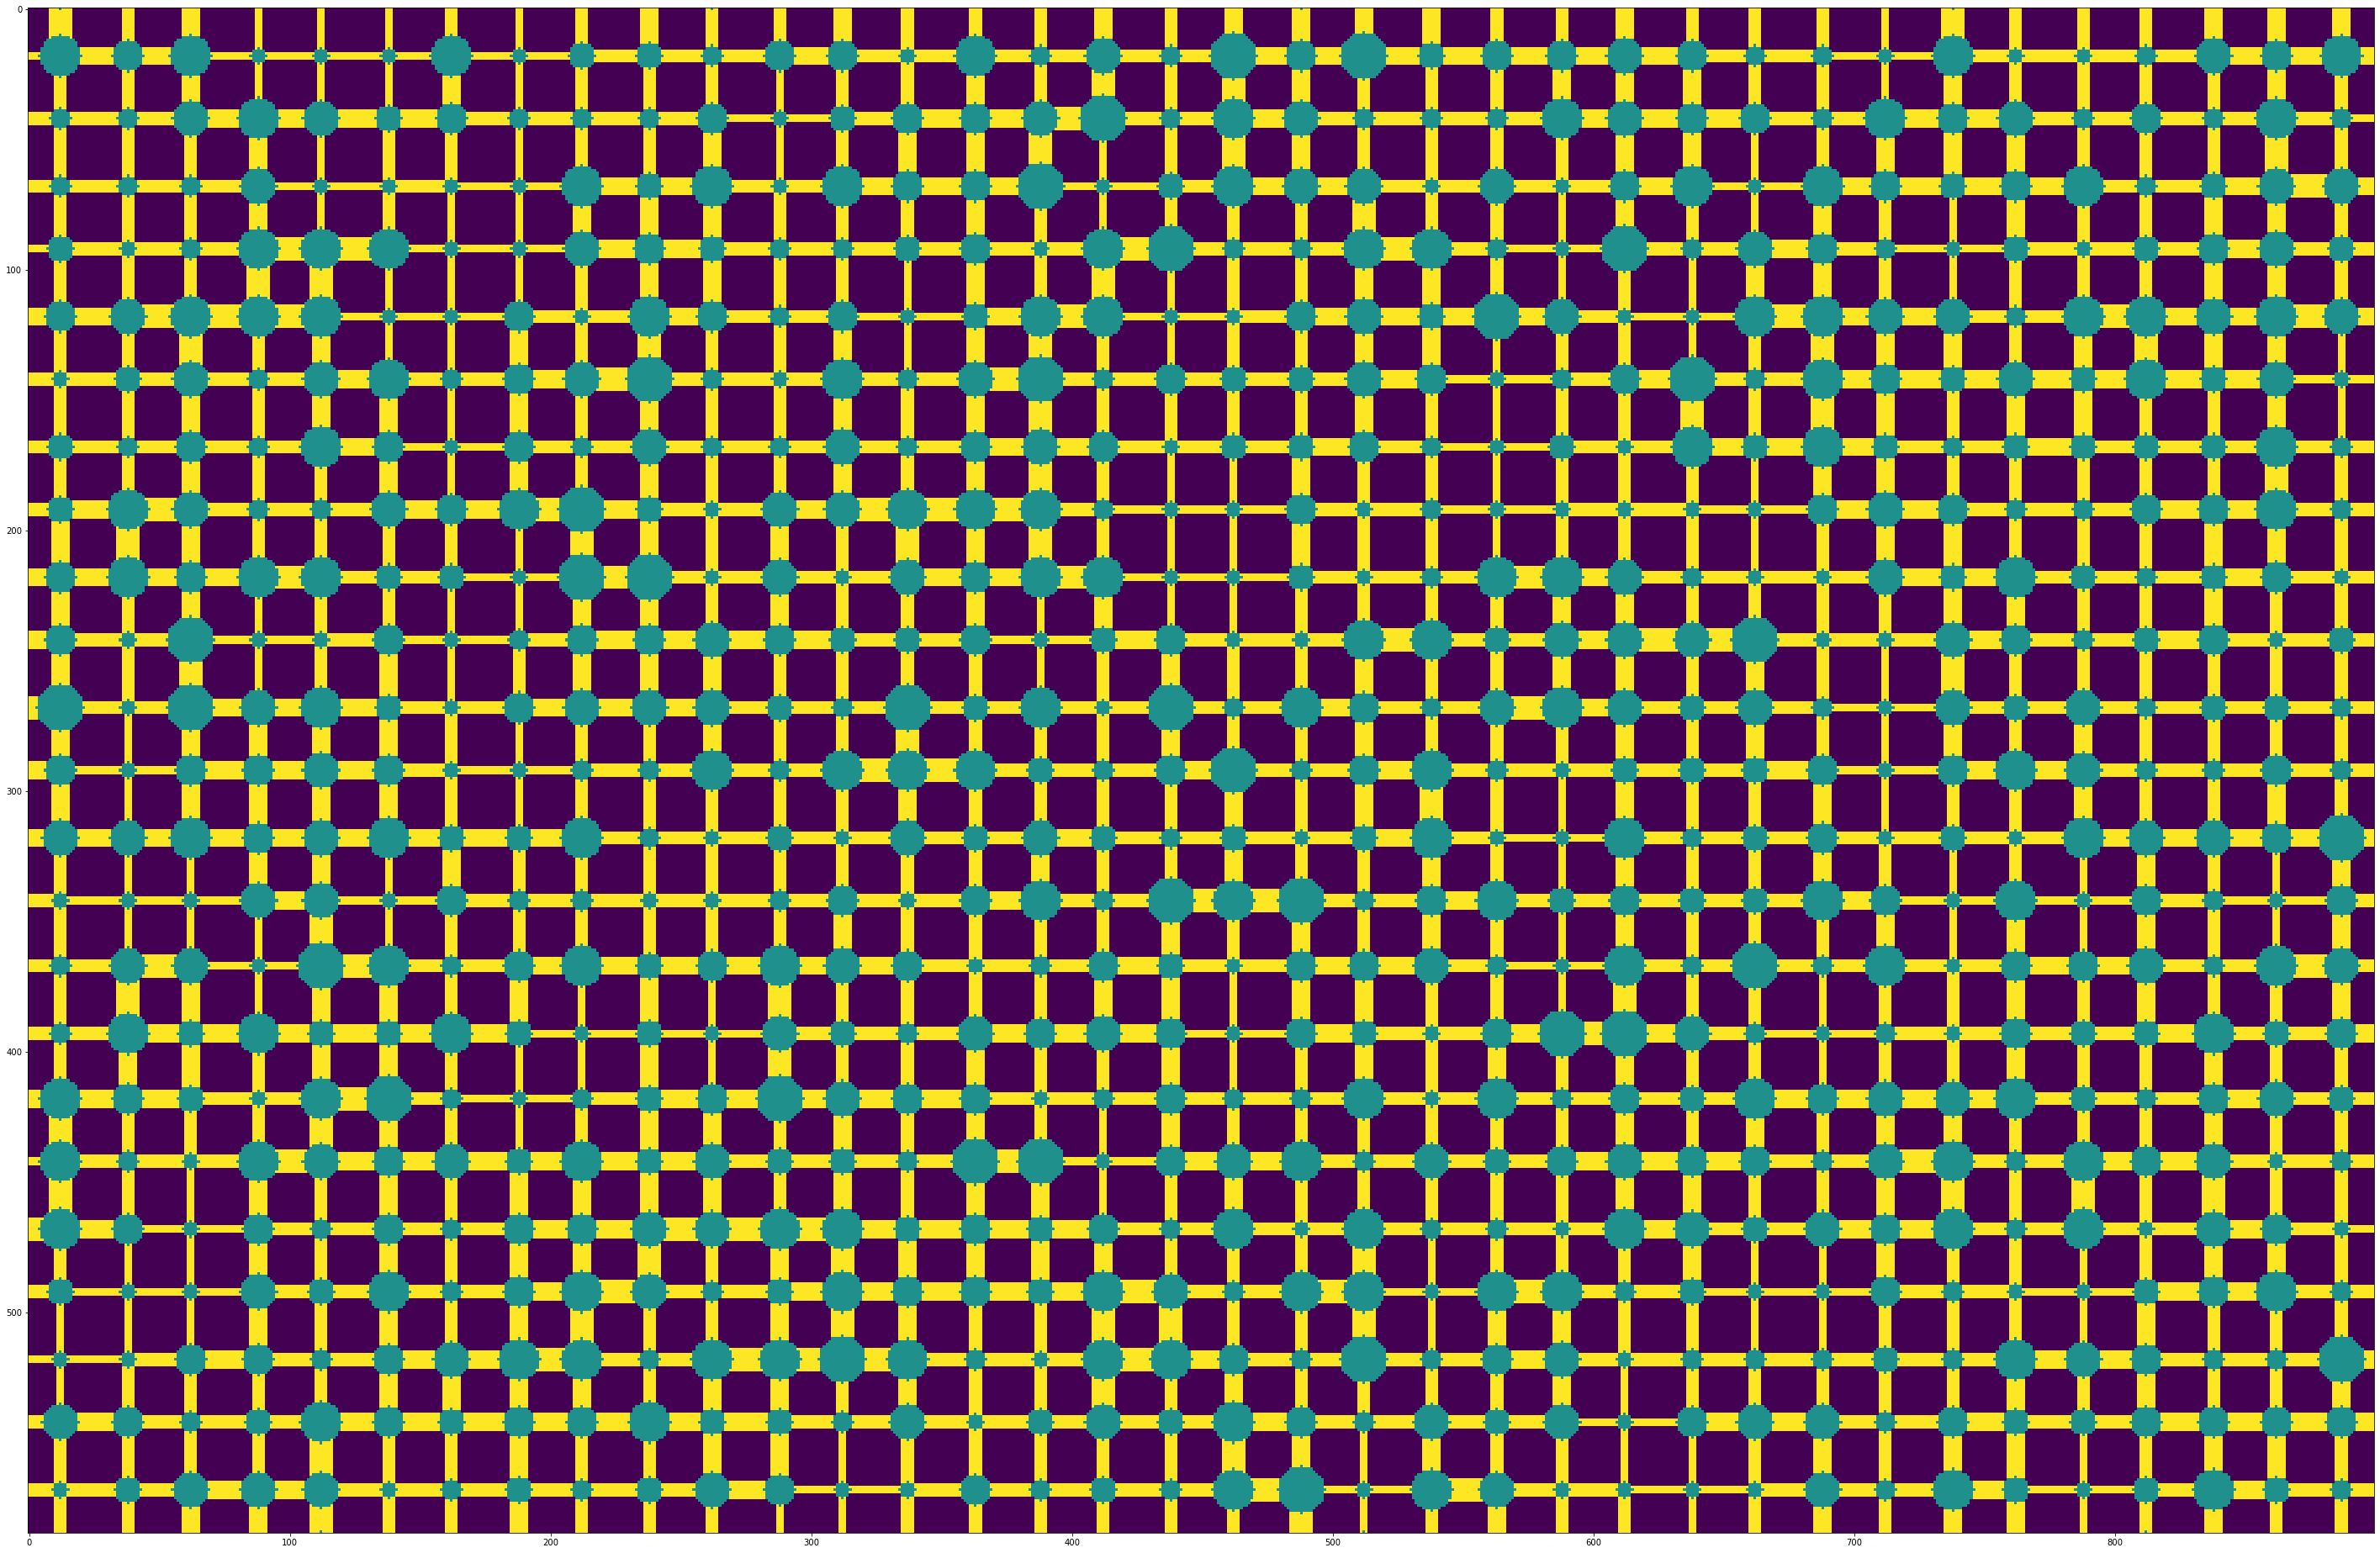

In [11]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(im[50:-50, 20:-20, 12].T)
crop = im[50:-50, 20:-20, 12]

In [12]:
snow_out = ps.networks.snow2(crop > 0, voxel_size=4e-7)

Extracting pore and throat properties:   0%|          | 0/1045 [00:00<?, ?it/s]

In [13]:
print(snow_out.regions.shape)

(906, 590)


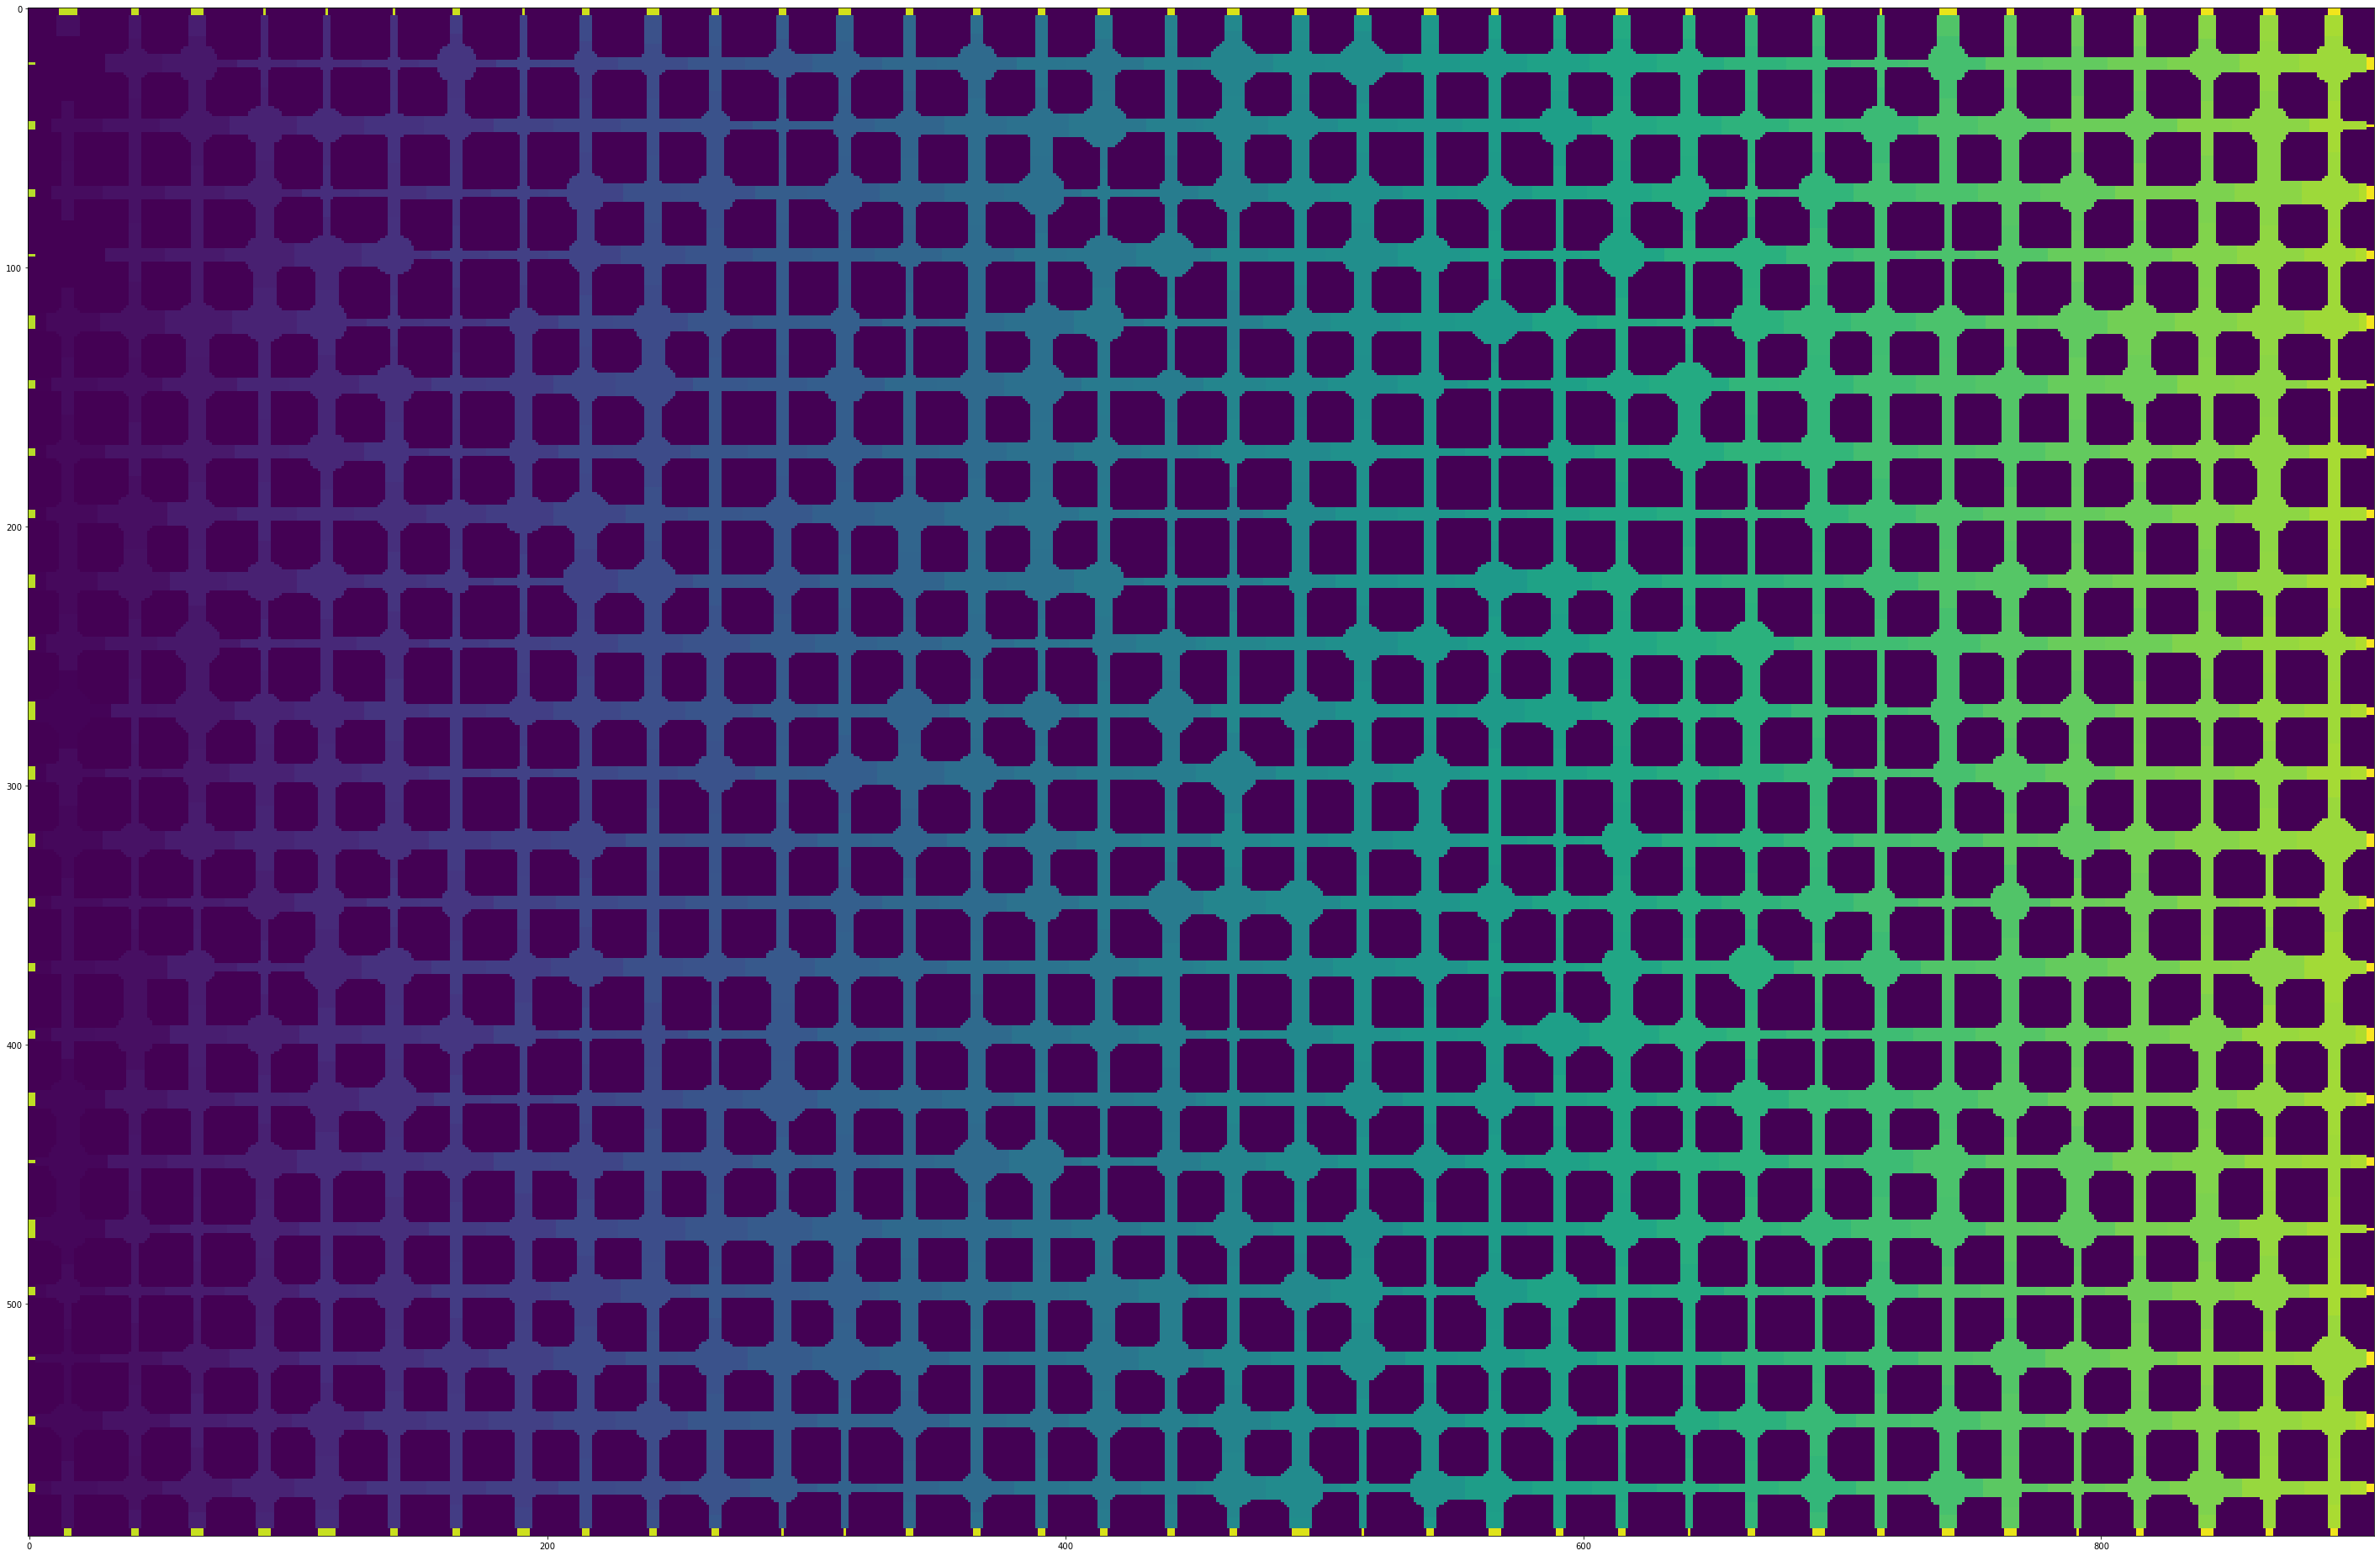

In [14]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(50, 50))
reg = snow_out.regions.astype(float) - 1
reg[reg == -1] = np.nan
region_slice = snow_out.regions[:, :] - 1
mask = region_slice >= 0
ax.imshow(region_slice.T);

In [15]:
wrk = op.Workspace()
wrk.clear()
net, geo = op.io.PoreSpy.import_data(snow_out.network)

In [16]:
def update_image(data):
    data = data.astype(float)
    out_im = np.ones(region_slice.shape, dtype=float)*-1
    out_im[mask] = data[region_slice[mask]]
    out_im[~mask] = np.nan
    return out_im

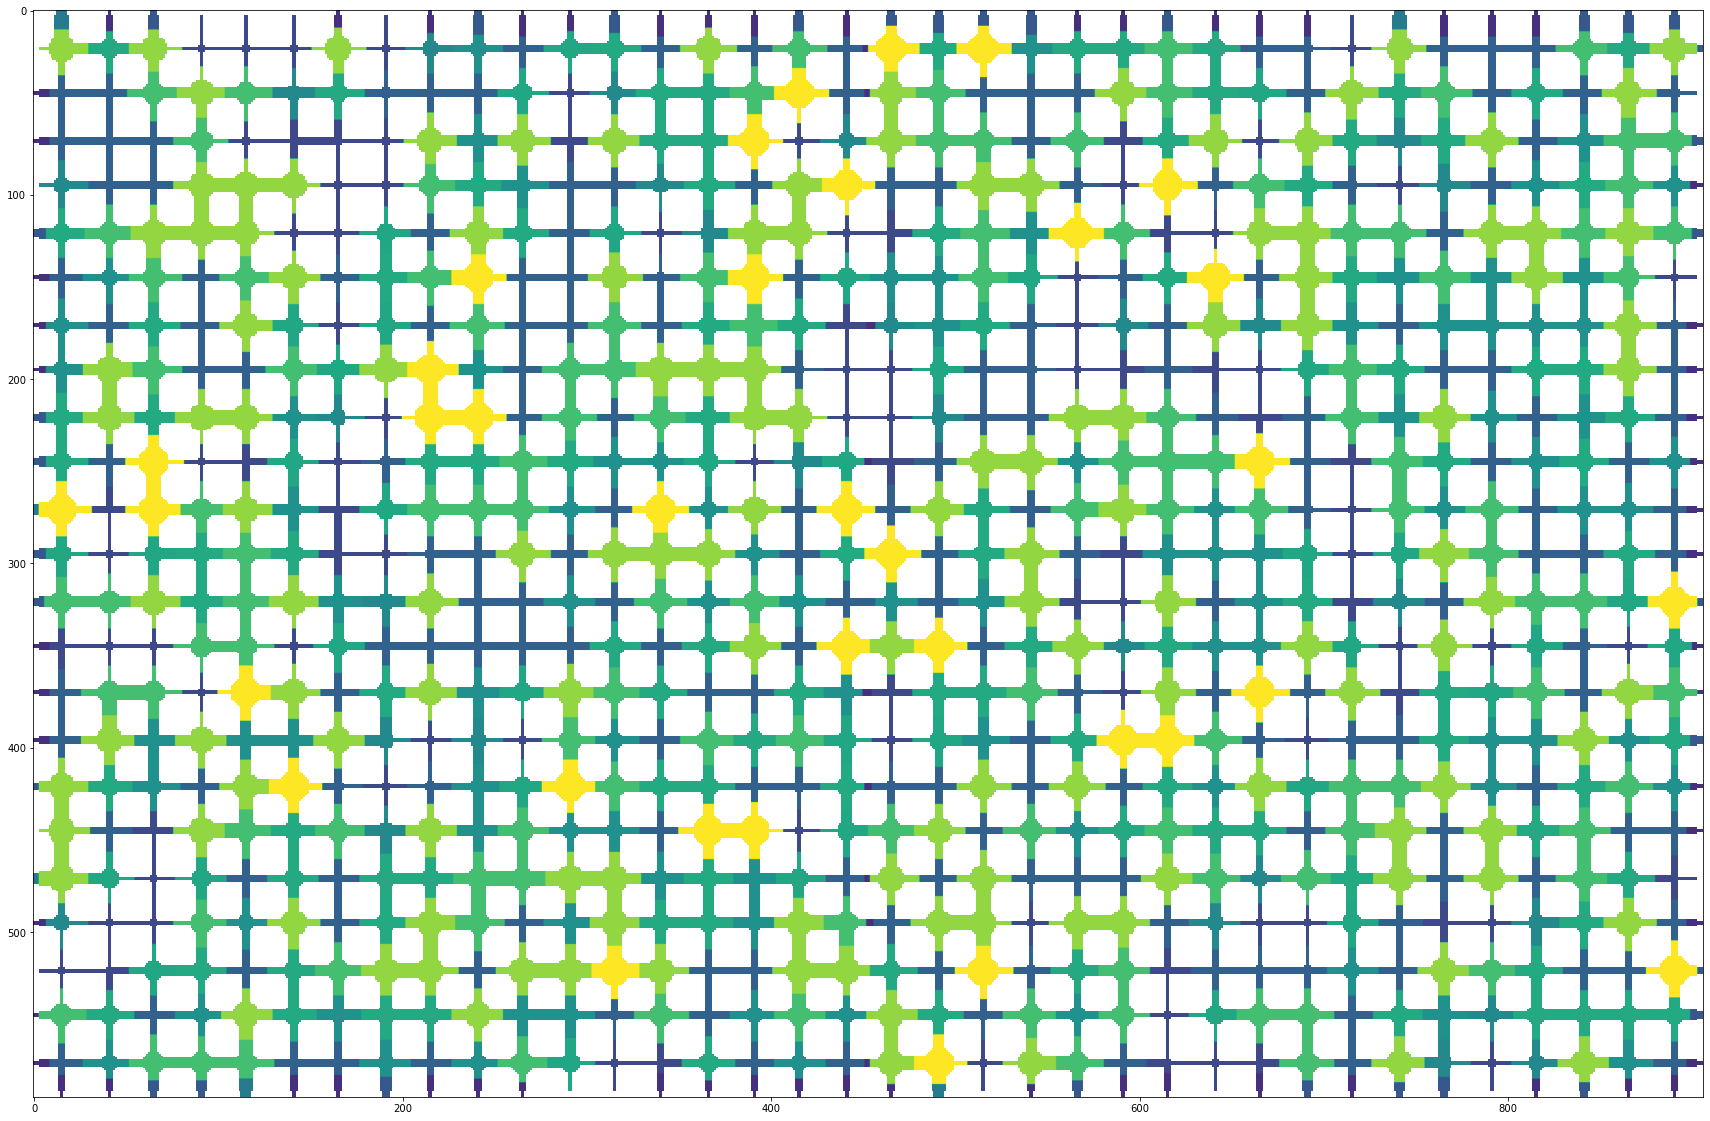

In [17]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(30, 20))
out = update_image(net['pore.diameter'])
ax.imshow(out.T);


In [30]:
air = op.phases.Air(network=net)
phys = op.physics.Basic(network=net, geometry=geo, phase=air)

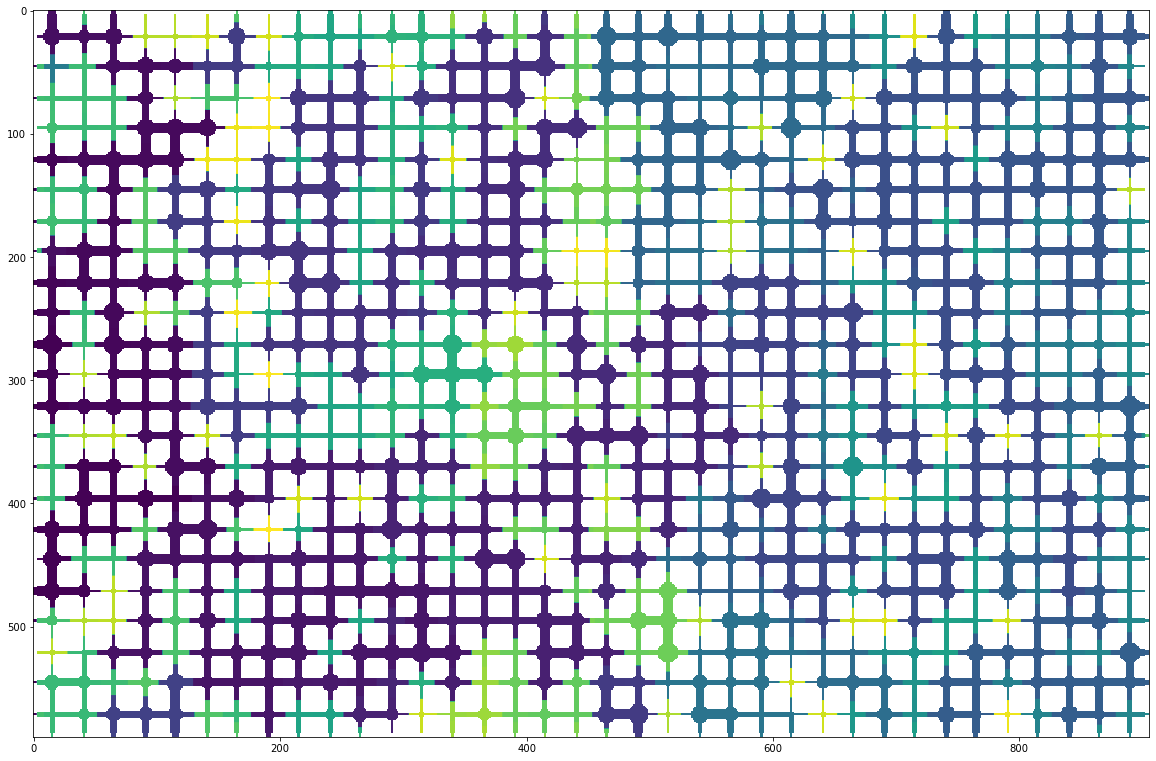

In [31]:
# NBVAL_IGNORE_OUTPUT
alg_ip = op.algorithms.InvasionPercolation(network=net, phase=air)
alg_ip.set_inlets(pores=net.pores('xmin'))
alg_ip.run()
fig, ax = plt.subplots(figsize=(20, 20))
out = update_image(alg_ip['pore.invasion_sequence'])
plt.imshow(out.T);

In [32]:
def plot_invasion(seq):
    data = alg_ip['pore.invasion_sequence'] < seq
    fig, ax = plt.subplots(figsize=(15, 15))
    out = update_image(data)
    plt.imshow(out.T);

In [33]:
max_seq = alg_ip['pore.invasion_sequence'].max()
interact(plot_invasion, seq=IntSlider(min=0, max=max_seq, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seq', max=1787), Output()), _dom_classes=('widget-inter…

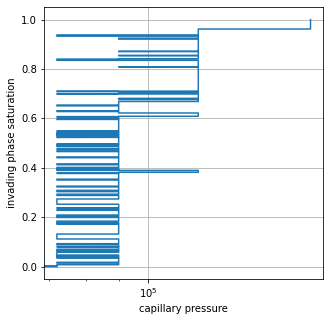

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
alg_ip.plot_intrusion_curve(ax)

------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2021-11-05 19:34:12,978
------------------------------------------------------------


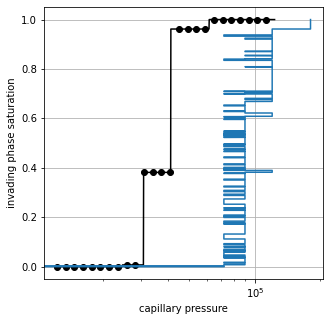

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
alg_op = op.algorithms.OrdinaryPercolation(network=net, phase=water)
alg_op.set_inlets(net.pores('xmin'))
alg_op.settings.update({'pore_volume': 'pore.volume',
                        'throat_volume': 'throat.volume'})
alg_op.run(points=1000)
alg_op.plot_intrusion_curve(ax)
alg_ip.plot_intrusion_curve(ax)

#### Running the algorithm again but with trapping

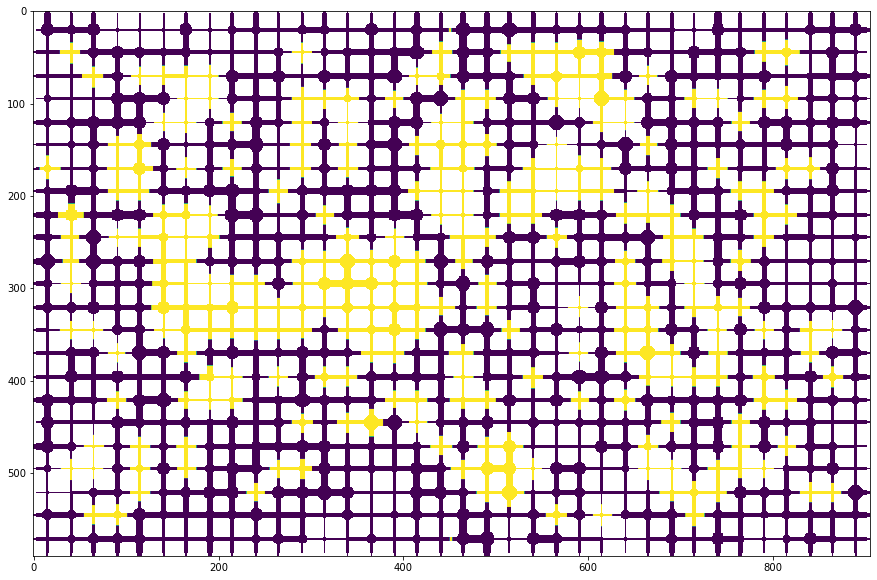

In [36]:
alg_ip_t = op.algorithms.InvasionPercolation(network=net, phase=water)
alg_ip_t.set_inlets(pores=net.pores('xmin'))
alg_ip_t.run()
alg_ip_t.apply_trapping(outlets=net.pores(['boundary']))
fig, ax = plt.subplots(figsize=(15, 15))
out = update_image(alg_ip_t['pore.trapped'])
ax.imshow(out.T);

In [37]:
max_seq = alg_ip_t['pore.invasion_sequence'].max()
interact(plot_invasion, seq=IntSlider(min=0, max=max_seq, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seq', max=1752), Output()), _dom_classes=('widget-inter…